Differential expression analysis of RNA-seq data 

Addressing question: Can you determine a specific set of genes for your cell lineage?
    
    -> we're trying to find genes wihich are specifically or highly expressed in ab tcells or gd tcells


AnnData object with n_obs × n_vars = 86 × 17535
    obs: 'cell_type'
    var: 'genes'


c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


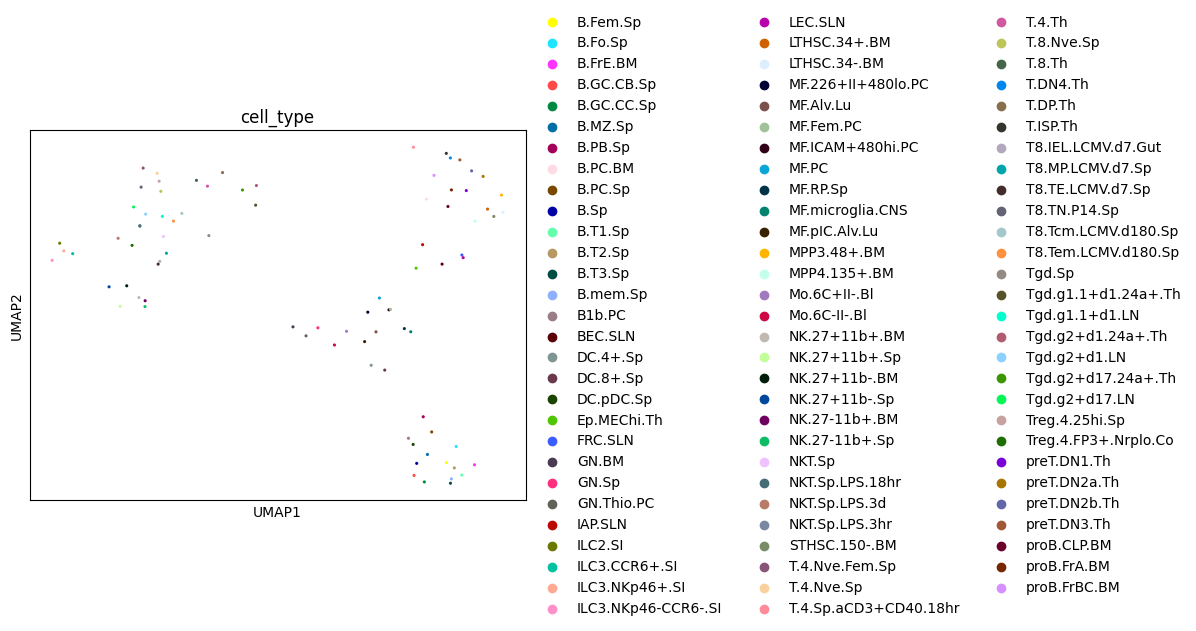

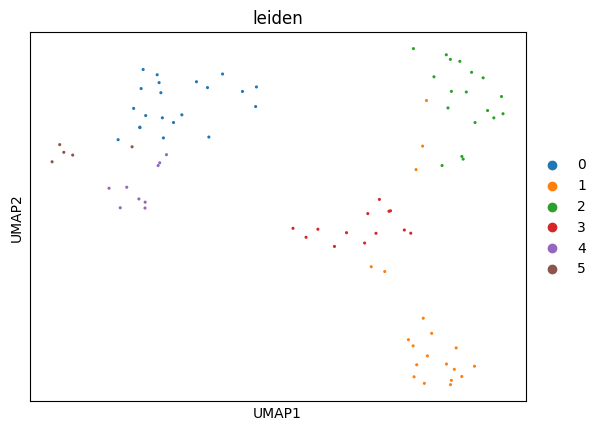

AnnData object with n_obs × n_vars = 86 × 17535
    obs: 'cell_type', 'leiden'
    var: 'genes'
    uns: 'cell_type_colors', 'leiden_colors'
    obsm: 'X_umap'
                   cell_type leiden
LTHSC.34-.BM    LTHSC.34-.BM      2
LTHSC.34+.BM    LTHSC.34+.BM      2
STHSC.150-.BM  STHSC.150-.BM      2
MPP4.135+.BM    MPP4.135+.BM      2
proB.CLP.BM      proB.CLP.BM      2


In [ ]:
# create anndata object

import pandas as pd
import scanpy as sc
import numpy as np
from anndata import AnnData

RNA_seq_path=r"C:\Users\helen\Downloads\datasets\mmc2.csv"
RNA_seq=pd.read_csv(RNA_seq_path,index_col=0)
RNA_seq_T=RNA_seq.T
RNA_seq_T_log = np.log1p(RNA_seq_T)  

adataRNA = AnnData(X=RNA_seq_T_log.values)
adataRNA.obs_names = RNA_seq_T_log.index        
adataRNA.var_names = RNA_seq_T_log.columns     

adataRNA.obs['cell_type'] = adataRNA.obs_names
adataRNA.var['genes'] = adataRNA.var_names

print(adataRNA)

#adding umap to anndata
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
RNA_seq_scaled = scaler.fit_transform(RNA_seq_T_log)

reducer = umap.UMAP(random_state=42)
umap_RNA = reducer.fit_transform(RNA_seq_scaled)

adataRNA.obsm['X_umap'] = umap_RNA

adataRNA.obs['cell_type'] = adataRNA.obs['cell_type'].astype('category')
sc.pl.umap(adataRNA, color='cell_type_annotated', size=20, legend_loc='on data', title='Annotated Clusters')

#adding leiden clusters to adata
leiden_clusters = pd.read_csv("leiden_clusters.csv", index_col=0)
assert all(leiden_clusters.index == adataRNA.obs_names)
adataRNA.obs['leiden'] = leiden_clusters["Leiden_Cluster"].astype(str)
sc.pl.umap(adataRNA, color='leiden', size=20)

#defining cell types to clusters
leiden_to_celltype = {
    '0': 'T helper',
    '1': 'γδ T cell',
    '2': 'B cell',
    '3': 'Monocyte',
    '4': 'NK cell', ???
}

adataRNA.obs['cell_type_annotated'] = adataRNA.obs['leiden'].map(leiden_to_celltype)
adataRNA.obs['cell_type_annotated'] = adataRNA.obs['cell_type_annotated'].astype('category')

sc.pl.umap(adataRNA, color='cell_type_annotated', size=20, title='UMAP with Cell Type Annotations')

#saving adata object
adataRNA.write("adataRNA.h5ad")
# loading the saved adata object
adataRNA_loaded = sc.read("adataRNA.h5ad")
print(adataRNA_loaded)
# checking the loaded adata object
print(adataRNA_loaded.obs.head())


In [ ]:
# labeling cells by lineage

def assign_lineage(celltype):
    if celltype.startswith('Tgd'):
        return 'GD_T'
    elif any(celltype.startswith(x) for x in ['T.4', 'T.8', 'T.DP', 'Treg', 'T8']):
        return 'AB_T'
    else:
        return 'Other'

adataRNA.obs['lineage'] = adataRNA.obs['cell_type'].apply(assign_lineage)